
# Lab02: Compressed DenseNet for Crowd Counting

> Dataset structure:
> ```
> <DATA_ROOT>/
> ├── Lab02_CDenseNet.ipynb
> ├── CDenseNet.py
> └── data/
>     ├── video/vidf/vidf1_33_ZZZ.y/*.png  # e.g., vidf1_33_ZZZ_fFFF.png ...
>     └── gt/vidf/*.mat    # e.g., vidf1_33_ZZZ_count_2K_roi*.mat ...
> ```

## 0. Mount Google Drive

In [12]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
# You need to modify this part to the directory where your code is located, i.e., <DATA_ROOT>
%cd "/content/drive/MyDrive/ColabNotebooks/DEEP_LEARNING/Lab02"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks/DEEP_LEARNING/Lab02


## 1. Import Libraries

In [1]:
%pip install torchinfo

In [2]:
# ---- import library ----
import os, re, glob, random
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
from scipy.io import loadmat

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms, utils as vutils
import matplotlib.pyplot as plt

%matplotlib inline

def set_global_seed(seed: int):
  # Python
  random.seed(seed)
  # NumPy
  np.random.seed(seed)
  # PyTorch
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  print(f"[INFO] Global seed set to {seed}")

set_global_seed(37)

[INFO] Global seed set to 37


## 2. Dataset Definition

In [3]:
# File naming for vidf frames: vidf1_33_ZZZ_fFFF.png (ZZZ: 000..019, FFF: 001..200)
FNAME_RE = re.compile(r"vidf1_33_(\d{3})_f(\d{3})\.png")

# Train: 401..2900 | Val: 2901..3600 | Test: 1..400 & 3601..4000
SPLIT_RANGES = {
  "train": [(401, 2900)],
  "val":   [(2901, 3600)],
  # "test":  [(1, 400), (3601, 4000)],   # full test set
  "test":  [(3601, 3800)],             # public test set
}

In [4]:
class UCSDDataset(Dataset):
  """
  UCSD vidf frames -> (x, people_cnts) where x is grayscale image tensor, people_cnts is [r, l, t] crowd counts for the frame.
  """
  def __init__(self, split: str = "train", transform=None):
    super().__init__()
    assert split in ["train", "val", "test"]
    self.img_dir = './data/video/vidf'
    self.gt_dir  = './data/gt/vidf'

    # preprocess transform: to tensor + normalize to [-1,1]
    self.transform = transform or transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # enumerate frames that belong to this split
    self.items: List[Tuple[int, int, str]] = []  # (clip_idx, f_in_clip, path)
    pngs = sorted(glob.glob(os.path.join(self.img_dir, "**", "*.png"), recursive=True))
    for p in pngs:
      m = FNAME_RE.match(os.path.basename(p))
      if not m:
        continue
      clip_str, f_str = m.groups()
      clip_idx = int(clip_str)           # 000..019
      f_in_clip = int(f_str)             # 001..200
      gidx = clip_idx * 200 + f_in_clip  # global indexing
      for a, b in SPLIT_RANGES[split]:
        if a <= gidx <= b:
          self.items.append((clip_idx, f_in_clip, p))
          break

    # cache for per-clip count .mat files
    self._count_cache: Dict[int, Dict[str, np.ndarray]] = {}

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    clip_idx, f_in_clip, img_p = self.items[idx]
    img = Image.open(img_p).convert('L')
    x = self.transform(img)
    dmap = self._load_counts_clip(clip_idx)
    k = f_in_clip - 1  # 0-based index into 200 frames
    r = dmap.get('r', None)
    l = dmap.get('l', None)
    t = dmap.get('t', None)
    if r is None or l is None or t is None:
      raise KeyError(f"[ERROR] Missing 'r','l','t' in dirs for clip {clip_idx}. Have={list(dmap.keys())}")
    people_cnts = torch.tensor([r[k], l[k], t[k]], dtype=torch.float32)
    return x, people_cnts

  def _load_counts_clip(self, clip_idx: int) -> Dict[str, np.ndarray]:
    """
      Loader for DT mat layout:
       - file:  vidf1_33_ZZZ_count_2K_roi_mainwalkway.mat
       - key:   'cgt' (1x1 struct)
       - fields: cgt.dir (['r','l','t','n']), cgt.count (cell of 4 vectors length 200)
      Returns dict {'r': vec, 'l': vec, 't': vec} as float32.
    """
    if clip_idx in self._count_cache:
      return self._count_cache[clip_idx]

    path = os.path.join(self.gt_dir, f"vidf1_33_{clip_idx:03d}_count_2K_roi_mainwalkway.mat")
    mat = loadmat(path, squeeze_me=False, struct_as_record=False)

    # 1x1 MATLAB struct at key 'cgt'
    entry = mat['cgt'].flat[0]  # get the single struct

    # Access fields
    dirs_raw   = getattr(entry, 'dir')
    counts_raw = getattr(entry, 'count')

    # Normalize to plain Python lists
    dirs_seq   = np.squeeze(dirs_raw).ravel()
    counts_seq = np.squeeze(counts_raw).ravel()

    # Convert names to strings and counts to float arrays
    dirs_list   = [str(np.squeeze(d).item()) for d in dirs_seq]
    counts_list = [np.squeeze(c).astype(np.float32) for c in counts_seq]  # (200,) each

    # Build the map; ignore 'n' (no motion)
    dmap = {}
    for name, vec in zip(dirs_list, counts_list):
      k = name.strip().lower()
      if   k == 'r': dmap['r'] = vec
      elif k == 'l': dmap['l'] = vec
      elif k == 't': dmap['t'] = vec

    missing = [nm for nm in ('r','l','t') if nm not in dmap]
    if missing:
      raise KeyError(f"[ERROR] Missing {missing} in GT for clip {clip_idx}. dirs={dirs_list}")

    # Cache & return
    self._count_cache[clip_idx] = dmap
    return dmap

## 3. Visualize Sample Frames & Labels

In [5]:
def visualize_samples(dataset: UCSDDataset, n: int = 4):
  """Show a grid of n sample images and print their [r,l,t] labels."""
  if len(dataset) == 0:
    print("[WARN] Dataset is empty. Please check DATA_ROOT.")
    return

  idxs = [random.randrange(len(dataset)) for _ in range(min(n, len(dataset)))]
  xs, ys = [], []
  for idx in idxs:
    x, people_cnts = dataset[idx]
    xs.append(x)
    ys.append(people_cnts.numpy())

  cols = min(8, len(xs))
  rows = int(np.ceil(len(xs) / cols))
  grid = vutils.make_grid(xs, nrow=cols, normalize=True, scale_each=True)

  plt.figure(figsize=(4.5*cols, 3.8*rows))  # Same scaling as lower function
  plt.axis('off')
  plt.title("Sample video frames (labels are [r, l, t])")
  plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap='gray')

  print("Labels [r, l, t] for shown samples:")
  for i, people_cnts in enumerate(ys):
    print(f"  #{i:02d} -> {[float(f'{v:.2f}') for v in people_cnts.tolist()]}")

try:
  _tmp_ds = UCSDDataset(split="train")
  visualize_samples(_tmp_ds, n=4)
except Exception as e:
  print("[WARN] Visualization skipped:", e)

[WARN] Dataset is empty. Please check DATA_ROOT.


## 4. Import Model

In [13]:
from CDenseNet import LDB, CDenseNet

model = CDenseNet()

In [14]:
model_summary = summary(model,
                       input_size=(1, 1, 158, 238),
                       device='cuda',
                       depth=9999,  # Large int value to show full depth
                       col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
                       row_settings=["var_names"])

print(model_summary)

with open('summary.txt', 'w') as f:
  f.write(str(model_summary))

print("[INFO] Summary displayed above and saved to summary.txt")

Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
CDenseNet (CDenseNet)                         [1, 1, 158, 238]          [1, 3]                    --                        --                        --
├─Sequential (stem)                           [1, 1, 158, 238]          [1, 32, 158, 238]         --                        --                        --
│    └─Conv2d (0)                             [1, 1, 158, 238]          [1, 32, 158, 238]         288                       [3, 3]                    10,829,952
│    └─BatchNorm2d (1)                        [1, 32, 158, 238]         [1, 32, 158, 238]         64                        --                        64
│    └─ReLU (2)                               [1, 32, 158, 238]         [1, 32, 158, 238]         --                        --                        --
├─Sequential (features)                       [1, 32, 158, 238]    

## 5. Create DataLoaders

In [ ]:
batch_size = 16

# Create dataset instances
train_ds = UCSDDataset(split="train")
val_ds   = UCSDDataset(split="val")
test_ds  = UCSDDataset(split="test")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"[INFO] Dataset sizes: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

[INFO] Dataset sizes: train=2500, val=700, test=200


## 6. Training Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)

# you can try 10~15 at first
num_epochs = 20
# Learning rate
lr = 1e-3

# Loss function
criterion = nn.SmoothL1Loss(beta=1.0)
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

[INFO] Using device: cuda


## 7. Training Loop

In [ ]:
from tqdm.auto import tqdm

model = model.to(device)

ckpt_path = "model.pth"

mae_best = float('inf')

for epoch in range(1, num_epochs + 1):
  # ---------- Training phase ----------
  model.train()  # Set the model to training mode
  running_loss = 0.0
  train_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs} [Train]', leave=False, position=0, smoothing=0.1)
  for in_img, people_cnts in train_bar:
    in_img, people_cnts = in_img.to(device, non_blocking=True), people_cnts.to(device, non_blocking=True)

    optimizer.zero_grad(set_to_none=True)
    pred_cnts = model(in_img)
    loss = criterion(pred_cnts, people_cnts)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * in_img.size(0)
    train_bar.set_postfix(loss=f"{loss.item():.4f}")

  epoch_loss = running_loss / len(train_loader.dataset)

  # ---------- Validation phase ----------
  model.eval()
  val_running_loss = 0.0
  abs_sum = torch.zeros(3, dtype=torch.double)
  sqr_sum = torch.zeros(3, dtype=torch.double)

  with torch.no_grad():
    val_bar = tqdm(val_loader, desc=f'Epoch {epoch}/{num_epochs} [Val]', leave=False, position=0, smoothing=0.1)
    for in_img, people_cnts in val_bar:
      in_img, people_cnts = in_img.to(device, non_blocking=True), people_cnts.to(device, non_blocking=True)
      pred_cnts = model(in_img)

      vloss = criterion(pred_cnts, people_cnts)
      val_running_loss += vloss.item() * in_img.size(0)

      err = (pred_cnts - people_cnts).double().cpu()
      abs_sum += err.abs().sum(dim=0)
      sqr_sum += (err ** 2).sum(dim=0)

  avg_val_loss = val_running_loss / len(val_loader.dataset)

  # MAE / RMSE（逐維度 r,l,t 與平均）
  n_val = len(val_loader.dataset)
  mae = (abs_sum / n_val).numpy()       # shape (3,)
  rmse = torch.sqrt(sqr_sum / n_val).numpy()
  avg_mae = float(mae.mean())
  avg_rmse = float(rmse.mean())

  # LR 調整（以驗證平均 MAE 監控）
  scheduler.step(avg_mae)

  # 儲存最佳（以 Avg MAE 判定）
  if avg_mae < mae_best:
    mae_best = avg_mae
    print("model saved")
    torch.save(model.state_dict(), ckpt_path)

  print(f"[Epoch {epoch:2d}] "
        f"Train Loss: {epoch_loss:8.4f} | "
        f" MAE[r,l,t] = [{mae[0]:7.4f}, {mae[1]:7.4f}, {mae[2]:7.4f}] | "
        f"Avg  MAE: {avg_mae:7.4f}")
  print(f"           "
        f"  Val Loss: {avg_val_loss:8.4f} | "
        f"RMSE[r,l,t] = [{rmse[0]:7.4f}, {rmse[1]:7.4f}, {rmse[2]:7.4f}] | "
        f"Avg RMSE: {avg_rmse:7.4f}")


Epoch 1/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

model saved
[Epoch  1] Train Loss:   7.7180 |  MAE[r,l,t] = [14.1564, 11.3474, 27.9614] | Avg  MAE: 17.8217
             Val Loss:  17.3217 | RMSE[r,l,t] = [14.4243, 11.7144, 28.1393] | Avg RMSE: 18.0927


Epoch 2/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

model saved
[Epoch  2] Train Loss:   2.6088 |  MAE[r,l,t] = [ 3.6799,  5.1602,  8.7839] | Avg  MAE:  5.8747
             Val Loss:   5.3838 | RMSE[r,l,t] = [ 4.2465,  5.9721,  9.1454] | Avg RMSE:  6.4546


Epoch 3/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

model saved
[Epoch  3] Train Loss:   2.0656 |  MAE[r,l,t] = [ 8.1158,  5.2754,  3.9662] | Avg  MAE:  5.7858
             Val Loss:   5.2964 | RMSE[r,l,t] = [ 8.7994,  6.0854,  4.6227] | Avg RMSE:  6.5025


Epoch 4/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

model saved
[Epoch  4] Train Loss:   1.7439 |  MAE[r,l,t] = [ 5.8675,  4.4228,  2.5287] | Avg  MAE:  4.2730
             Val Loss:   3.7980 | RMSE[r,l,t] = [ 6.8181,  5.1449,  3.1503] | Avg RMSE:  5.0378


Epoch 5/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

model saved
[Epoch  5] Train Loss:   1.6350 |  MAE[r,l,t] = [ 4.7815,  3.7512,  2.1443] | Avg  MAE:  3.5590
             Val Loss:   3.0871 | RMSE[r,l,t] = [ 5.5584,  4.3966,  2.6863] | Avg RMSE:  4.2138


Epoch 6/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

model saved
[Epoch  6] Train Loss:   1.4273 |  MAE[r,l,t] = [ 2.9843,  2.8266,  3.7995] | Avg  MAE:  3.2035
             Val Loss:   2.7373 | RMSE[r,l,t] = [ 3.6211,  3.5380,  4.3721] | Avg RMSE:  3.8437


Epoch 7/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch  7] Train Loss:   1.5399 |  MAE[r,l,t] = [ 7.7143,  3.0557,  6.5429] | Avg  MAE:  5.7710
             Val Loss:   5.2888 | RMSE[r,l,t] = [ 8.3588,  3.7683,  7.0837] | Avg RMSE:  6.4036


Epoch 8/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

model saved
[Epoch  8] Train Loss:   1.1599 |  MAE[r,l,t] = [ 2.6447,  2.7843,  3.4521] | Avg  MAE:  2.9604
             Val Loss:   2.4983 | RMSE[r,l,t] = [ 3.2821,  3.4284,  3.9884] | Avg RMSE:  3.5663


Epoch 9/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch  9] Train Loss:   1.1480 |  MAE[r,l,t] = [ 7.9837,  9.1130,  2.0863] | Avg  MAE:  6.3943
             Val Loss:   5.9155 | RMSE[r,l,t] = [ 8.6541,  9.7347,  2.6251] | Avg RMSE:  7.0047


Epoch 10/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 10] Train Loss:   1.0697 |  MAE[r,l,t] = [ 3.6307,  4.0427,  1.6849] | Avg  MAE:  3.1195
             Val Loss:   2.6551 | RMSE[r,l,t] = [ 4.4393,  4.7673,  2.1117] | Avg RMSE:  3.7728


Epoch 11/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 11] Train Loss:   1.0103 |  MAE[r,l,t] = [ 6.2935,  4.9858,  2.3163] | Avg  MAE:  4.5318
             Val Loss:   4.0523 | RMSE[r,l,t] = [ 7.0902,  5.8361,  2.8266] | Avg RMSE:  5.2510


Epoch 12/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 12] Train Loss:   0.9220 |  MAE[r,l,t] = [ 2.3544, 13.9438, 15.0619] | Avg  MAE: 10.4533
             Val Loss:   9.9685 | RMSE[r,l,t] = [ 2.9037, 14.3895, 15.2367] | Avg RMSE: 10.8433


Epoch 13/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 13] Train Loss:   0.8282 |  MAE[r,l,t] = [ 4.6982,  4.4035,  8.5422] | Avg  MAE:  5.8813
             Val Loss:   5.3904 | RMSE[r,l,t] = [ 5.5169,  5.2596,  8.8112] | Avg RMSE:  6.5292


Epoch 14/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

model saved
[Epoch 14] Train Loss:   0.8742 |  MAE[r,l,t] = [ 2.0464,  2.8747,  2.5623] | Avg  MAE:  2.4945
             Val Loss:   2.0352 | RMSE[r,l,t] = [ 2.3847,  3.5232,  3.2346] | Avg RMSE:  3.0475


Epoch 15/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 15] Train Loss:   0.8124 |  MAE[r,l,t] = [ 3.3583,  2.8359,  3.7458] | Avg  MAE:  3.3133
             Val Loss:   2.8451 | RMSE[r,l,t] = [ 4.1542,  3.5035,  4.3281] | Avg RMSE:  3.9953


Epoch 16/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 16] Train Loss:   0.8194 |  MAE[r,l,t] = [ 2.8728,  3.0083,  2.0216] | Avg  MAE:  2.6342
             Val Loss:   2.1793 | RMSE[r,l,t] = [ 3.6268,  3.6516,  2.5776] | Avg RMSE:  3.2853


Epoch 17/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 17] Train Loss:   0.8166 |  MAE[r,l,t] = [ 3.2124,  2.8008,  3.4374] | Avg  MAE:  3.1502
             Val Loss:   2.6828 | RMSE[r,l,t] = [ 4.0466,  3.4624,  4.0351] | Avg RMSE:  3.8480


Epoch 18/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 18] Train Loss:   0.7840 |  MAE[r,l,t] = [ 2.9275,  2.8885,  2.4590] | Avg  MAE:  2.7583
             Val Loss:   2.2950 | RMSE[r,l,t] = [ 3.6807,  3.5021,  3.0428] | Avg RMSE:  3.4085


Epoch 19/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 19] Train Loss:   0.6615 |  MAE[r,l,t] = [ 5.4212,  3.6275,  3.4981] | Avg  MAE:  4.1823
             Val Loss:   3.7033 | RMSE[r,l,t] = [ 6.3613,  4.3306,  4.1282] | Avg RMSE:  4.9400


Epoch 20/20 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

[Epoch 20] Train Loss:   0.5758 |  MAE[r,l,t] = [ 2.7360,  3.0402,  1.9024] | Avg  MAE:  2.5596
             Val Loss:   2.1070 | RMSE[r,l,t] = [ 3.4722,  3.6926,  2.3865] | Avg RMSE:  3.1838


## 8. Inference on Test Set

[INFO] Loaded model state dict from checkpoint: model.pth


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

[TEST]  MAE[r,l,t] = [2.5879, 1.8609, 1.5457] | Avg  MAE = 1.9982
[TEST] RMSE[r,l,t] = [2.8653, 2.2349, 1.9857] | Avg RMSE = 2.3620


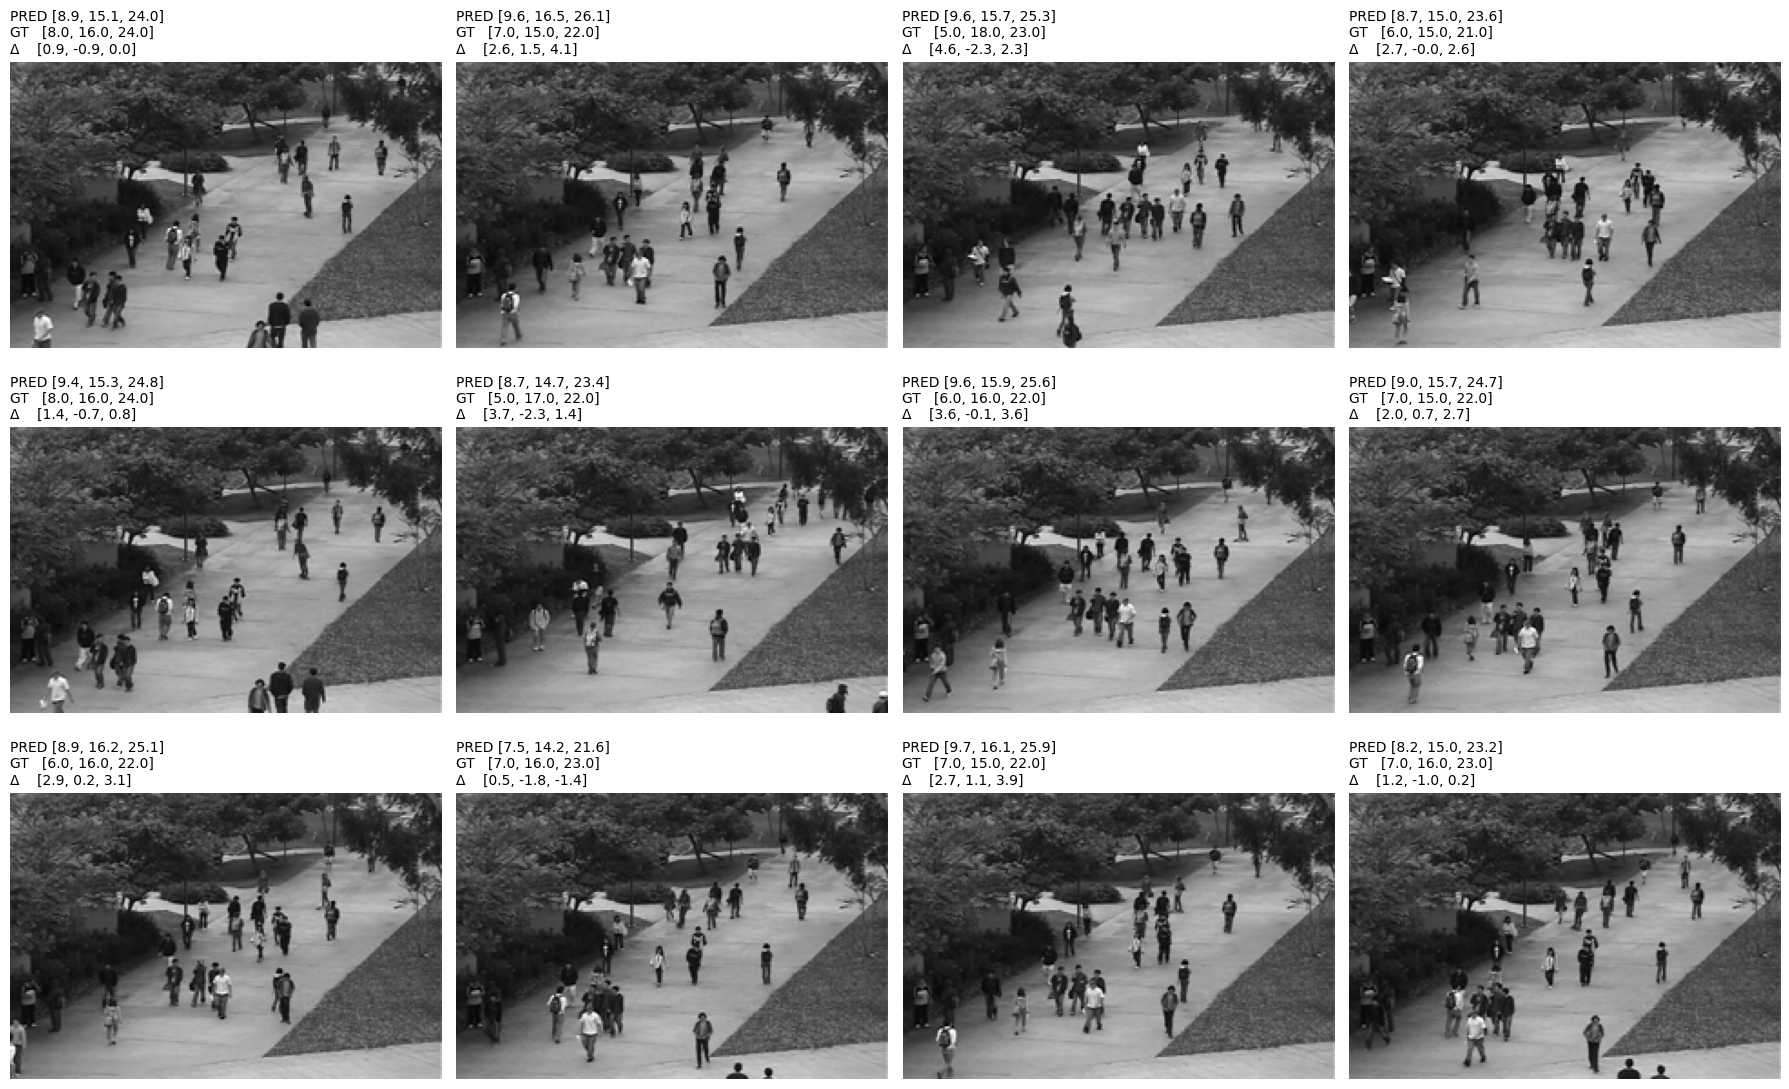

In [ ]:
from tqdm.auto import tqdm

_ckpt_path = ckpt_path if 'ckpt_path' in globals() else 'model.pth'

if os.path.exists(_ckpt_path):
  try:
    # Load checkpoint
    ck = torch.load(_ckpt_path, map_location=device)
    model.load_state_dict(ck)
    print(f"[INFO] Loaded model state dict from checkpoint: {_ckpt_path}")

  except Exception as e:
    print(f"[ERROR] Error loading checkpoint {_ckpt_path}: {e}")
    print("[WARN] Evaluating current in-memory weights.")
else:
  print("[WARN] No checkpoint found; evaluating current in-memory weights.")

model.eval()
abs_sum = torch.zeros(3, dtype=torch.float64)
sqr_sum = torch.zeros(3, dtype=torch.float64)

# Image number to display after testing
num_show = 12
sampled = []
seen = 0

with torch.no_grad():
  test_bar = tqdm(test_loader, desc="Evaluating", leave=False)
  for batch_idx, (in_img, people_cnts) in enumerate(test_bar):
    in_img = in_img.to(device, non_blocking=True)
    people_cnts = people_cnts.to(device, non_blocking=True)
    pred_cnts = model(in_img)

    err = pred_cnts - people_cnts
    abs_sum += err.abs().sum(dim=0).double().cpu()
    sqr_sum += (err**2).sum(dim=0).double().cpu()

    # Reservoir sampling: keep a random 12 from the whole stream
    B = in_img.size(0)
    for i in range(B):
      if len(sampled) < num_show:
        sampled.append((
          in_img[i].detach().cpu(),
          people_cnts[i].detach().cpu(),
          pred_cnts[i].detach().cpu()
        ))
      else:
        j = random.randint(0, seen)
        if j < num_show:
          sampled[j] = (
            in_img[i].detach().cpu(),
            people_cnts[i].detach().cpu(),
            pred_cnts[i].detach().cpu()
          )
      seen += 1

    test_bar.set_postfix({
      'MAE[r, l, t]' : [f"{(abs_sum[i]/((batch_idx + 1) * people_cnts.size(0))):.4f}" for i in range(3)],
      'RMSE[r, l, t]': [f"{(sqr_sum[i]/((batch_idx + 1) * people_cnts.size(0))).sqrt().item():.4f}" for i in range(3)],
    })

# Calculate final metrics
test_mae = (abs_sum / len(test_ds)).tolist()
test_rmse = torch.sqrt(sqr_sum / len(test_ds)).tolist()

# Print results
print(f"[TEST]  MAE[r,l,t] = [{test_mae[0]:.4f}, {test_mae[1]:.4f}, {test_mae[2]:.4f}] | "
      f"Avg  MAE = {(sum(test_mae)/3):.4f}")
print(f"[TEST] RMSE[r,l,t] = [{test_rmse[0]:.4f}, {test_rmse[1]:.4f}, {test_rmse[2]:.4f}] | "
      f"Avg RMSE = {(sum(test_rmse)/3):.4f}")

# Plotting
n = len(sampled)
cols = min(4, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 3.8*rows))
if rows == 1 and cols == 1:
  axes = np.array([[axes]])
elif rows == 1:
  axes = np.array([axes])

for idx, (img, gt, pred) in enumerate(sampled):
  ax = axes[idx // cols, idx % cols]
  img = (img * 0.5 + 0.5).clamp(0, 1).squeeze(0).numpy()
  ax.imshow(img, cmap='gray')
  ax.axis('off')
  gt_np = gt.numpy(); pr_np = pred.numpy(); delta = pr_np - gt_np
  ax.set_title(
    f"PRED [{pr_np[0]:.1f}, {pr_np[1]:.1f}, {pr_np[2]:.1f}]\n"
    f"GT   [{gt_np[0]:.1f}, {gt_np[1]:.1f}, {gt_np[2]:.1f}]\n"
    f"Δ    [{delta[0]:.1f}, {delta[1]:.1f}, {delta[2]:.1f}]",
    fontsize=10, loc='left'
  )

for j in range(n, rows*cols):
  axes[j // cols, j % cols].axis('off')

plt.tight_layout()
plt.show()